# Figure 2

- Notebook to make data for figure 2 (likely a map)
- by Cascade Tuholske on 2020.10.01

#### Depdencies

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import seaborn as sns
import glob

#### Functions

In [32]:
def make_pdays(df_stats, df_pop):
    
    "Makes a dataframe with stats and population to calc people days"
    
    # Make Population Long Format
    pop_long = pd.wide_to_long(df_pop, stubnames = 'P', i = 'ID_HDC_G0', j = 'year')
    pop_long.reset_index(level=0, inplace=True)
    pop_long.reset_index(level=0, inplace=True)
    pop_long = pop_long.drop('Unnamed: 0', axis = 1)
    
    # Get Total Days 
    data = df_stats.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
    pdays = pd.DataFrame()
    pdays['ID_HDC_G0'] = data['ID_HDC_G0']
    pdays['year'] = data['year']
    pdays['total_days'] = data['total_days']
    pdays['CTR_MN_NM'] = data['CTR_MN_NM']
    pdays['sub-region'] = data['sub-region']
    pdays['region'] = data['region']
    pdays['intermediate-region'] = data['intermediate-region']
    
    # Merge
    pdays_merge = pdays.merge(pop_long, on=['ID_HDC_G0', 'year'], how = 'left')

    # Now get people days from 1983 and change
    p = pd.DataFrame()
    p['ID_HDC_G0'] = df_pop['ID_HDC_G0']
    p['P1983'] = df_pop['P1983']
    p['P2016'] = df_pop['P2016']
#    p['p_delt'] = (df_pop['P2016'] - df_pop['P1983']) / df_pop['P1983'] * 100

    pdays_merge = pdays_merge.merge(p ,on=['ID_HDC_G0'], how = 'left')
    
    # Calc p days = total days i * pop i 
    pdays_merge['people_days'] = pdays_merge['total_days'] * pdays_merge['P'] #/ 10**9 # total people days
    
    # Pdays due to heat increase = total days i - pop 83 - (total days 83 - pop 83) <<-- back out when graphing
    pdays_merge['people_days_heat'] = pdays_merge['total_days'] * pdays_merge['P1983'] #/ 10**9 # people days w/ pop con
    
    # Pdays due to pop increase = total days i * (pop i - pop 83)
    pdays_merge['people_days_pop'] = pdays_merge['total_days'] *(pdays_merge['P'] - pdays_merge['P1983']) #/10**9 # dif

    
    return pdays_merge

In [33]:
def pop_stat(df, geog, stats):
    
    """Finds linear coef for increase in stat by a given geography from 1983 - 2016, as well
    as the pct change in population of the cities within the given geography"""

    # Get results
    labels = []
    delt_list = []
    r2_list = []
    coef_list = []
    p_list = []
    df_out = pd.DataFrame()

    for label, df_geog in df.groupby(geog):

        # Get Data
        X_year = np.array(df_geog.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
        Y_stats = np.array(df_geog.groupby('year')[stats].sum()).reshape((-1, 1))

        # Add Intercept
        X_year_2 = sm.add_constant(X_year)

        # Regress
        model = sm.OLS(Y_stats, X_year_2).fit() 
        
        # Get slope
        # first param in intercept coef, second is slope of line but if slope = 0, then intecept
        if len(model.params) == 2:
            coef = model.params[1]
            
        else:
            coef = model.params[0]
        
        # R2 and P
        r2 = model.rsquared_adj
        p = model.pvalues[0]

        # Pop change
        delt = (df_geog['P2016'].sum() - df_geog['P1983'].sum())/df_geog['P1983'].sum() * 100

        # Make lists
        labels.append(label)
        r2_list.append(r2)
        coef_list.append(coef)
        p_list.append(p)
        delt_list.append(delt)

    # Make data frame
    df_out[geog] = labels
    df_out['p_delt'] = delt_list
    df_out['r2'] = r2_list
    df_out['coef'] = coef_list
    df_out['p_value'] = [round(elem, 4) for elem in p_list]

    return df_out

# Load and Make Data

In [34]:
# file paths
DATA_IN = "/home/cascade/projects/data_out_urbanheat/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FN_stats = 'heatrange/All_data20200109_406C_es_final.csv'
df_stats = pd.read_csv(DATA_IN+FN_stats)
# FIG_OUT = '/home/cascade/projects/figures/'

FN_pop = 'GHS-UCDB-Interp.csv'
df_pop = pd.read_csv(DATA_IN+FN_pop)

In [35]:
df_data = make_pdays(df_stats, df_pop)

In [36]:
df_data.head()

,ID_HDC_G0,year,total_days,CTR_MN_NM,sub-region,region,intermediate-region,P,P1983,P2016,people_days,people_days_heat,people_days_pop
0,2784,1983,1,Germany,Western Europe,Europe,Western Europe,9.976361e+05,997636.118717,1.573652e+06,9.976361e+05,997636.118717,0.000000
1,2784,2013,1,Germany,Western Europe,Europe,Western Europe,1.538112e+06,997636.118717,1.573652e+06,1.538112e+06,997636.118717,540475.589177
2,2833,1983,1,Germany,Western Europe,Europe,Western Europe,6.014093e+04,60140.932532,6.497856e+04,6.014093e+04,60140.932532,0.000000
3,2833,1984,1,Germany,Western Europe,Europe,Western Europe,6.033127e+04,60140.932532,6.497856e+04,6.033127e+04,60140.932532,190.332532
4,2833,1998,1,Germany,Western Europe,Europe,Western Europe,6.411484e+04,60140.932532,6.497856e+04,6.411484e+04,60140.932532,3973.903796


# Sub-Region Level Change

Here we want find the regions with the greatest increase in the total numbers of exposure days in a given year and then make graphs at the country level with a sig. trend line

In [37]:
# Find Regions where the trend in people days due to heat is sig at 0.05

stat = 'people_days_heat'
geog = 'sub-region'
df_region = pop_stat(df_data, geog, stat)
df_region = df_region[df_region['p_value'] < 0.05]
sig_regions = list(df_region[geog])
len(sig_regions)

7

In [38]:
# Sub set all data
# df_region_data = df_data[df_data[geog].isin(sig_regions)]

/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


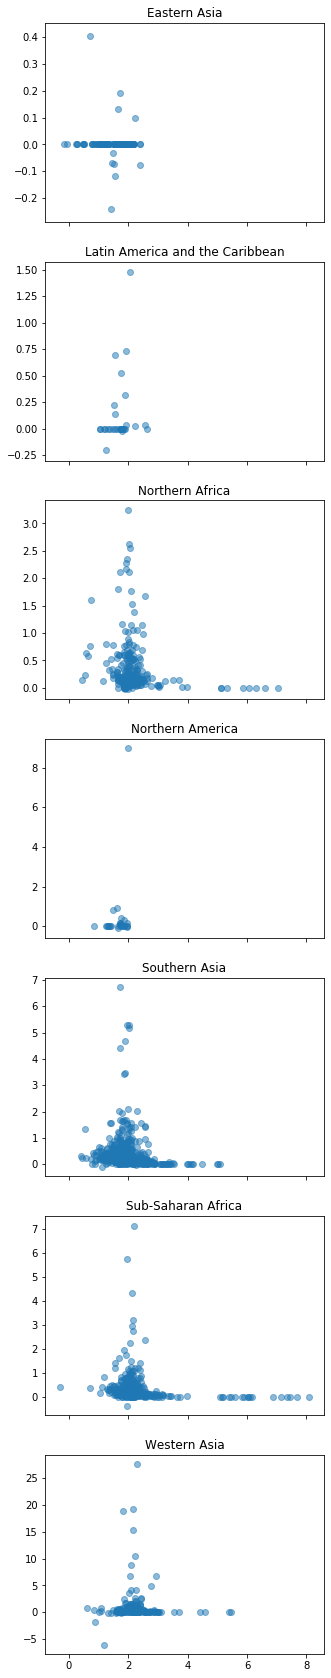

In [57]:
fig, axs = plt.subplots(7, 1, figsize = (5, 30), sharex=True)
axs = axs.ravel()
counter = 0

for i, region in enumerate(sig_regions):
    
    df_region = df_data[df_data[geog] == region] # select region
    
    countries = pop_stat(df_region, 'ID_HDC_G0', stat) # get stats
    countries = countries[countries['p_value'] < 0.05] # subset

    # plot it
    axs[i].scatter(np.log10(countries['p_delt']), countries['coef']/10**5, alpha = 0.5)
    axs[i].set_title(region, fontsize = 12)
    
    counter = counter + i
#     if counter == 0:
#         axs[i].set_ylabel('People-days [hundred-thousands]', fontsize = 13)
#     # Set lims
# #     axs[i].set_ylim(bottom = 0)
# #     #axs[i].set_xlim([0, 800])


    
#     #print(countries['CTR_MN_NM'])
    
#     for j, row in countries.iterrows():
#         axs[i].annotate(row['CTR_MN_NM'], (row['p_delt'], row['coef']))

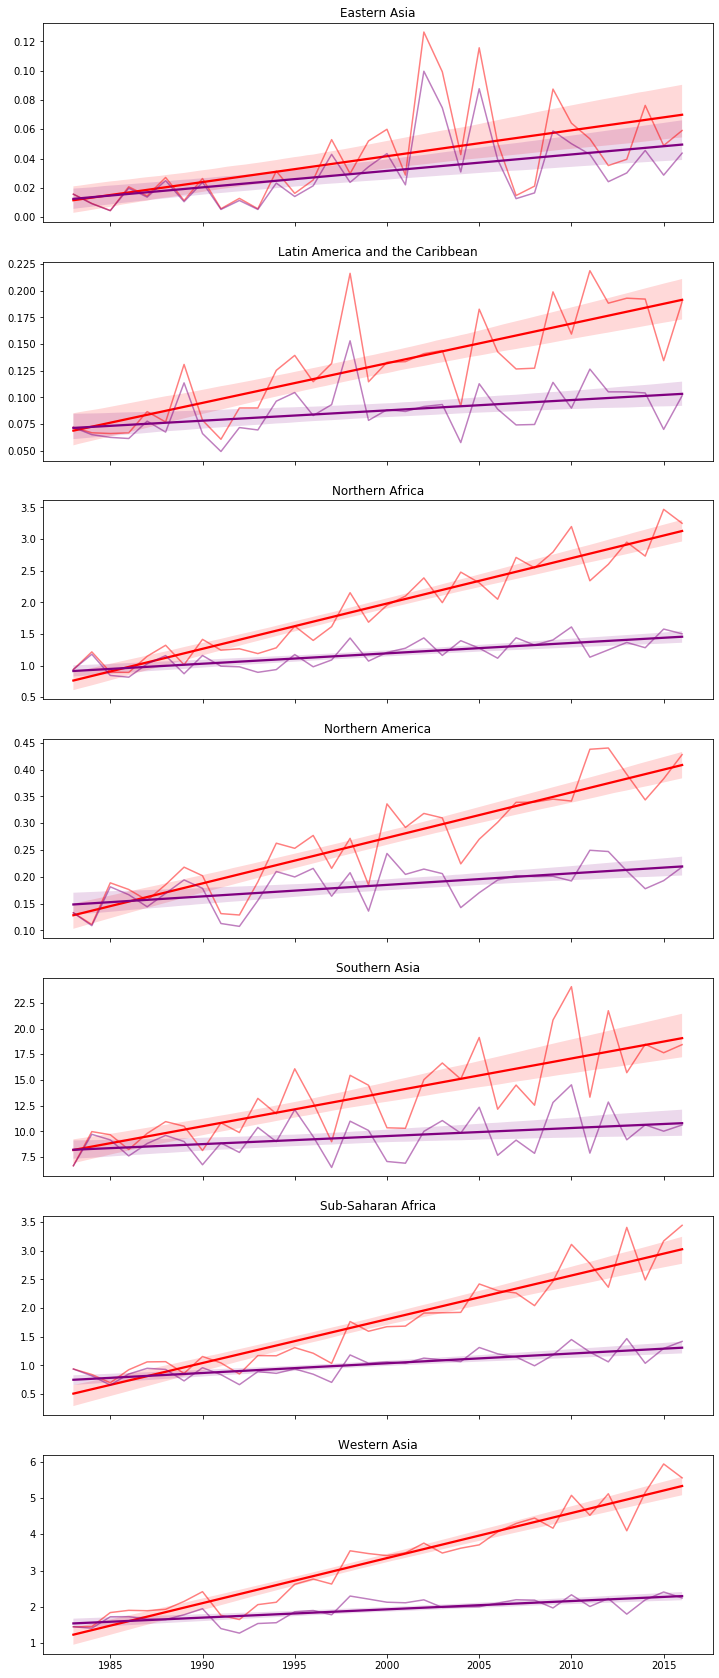

In [54]:
# plot by region
geog = 'sub-region'

fig, axs = plt.subplots(7, figsize = (12,30), sharex=True)

axs = axs.ravel()

for i, region in enumerate(sig_regions):
    
    # people days plot
    data = df_data[df_data[geog] == region].groupby('year')['people_days'].sum() / 10**9
    years = list(data.index)
    axs[i].plot(data, color = 'red', linestyle = '-', alpha = 0.5)
    #axs[i].fill_between(years, data, color = 'red', alpha = 0.05, label='_nolegend_')
    sns.regplot(years, data, color = 'red', ax = axs[i], scatter = False, truncate = True)
    
    # people days 83 plot
    data = df_data[df_data[geog] == region].groupby('year')['people_days_heat'].sum() / 10**9
    years = list(data.index)
    axs[i].plot(data, color = 'purple', linestyle = '-', alpha = 0.5)
    #axs[i].fill_between(years, data, color = 'purple', alpha = 0.1, label='_nolegend_')
    sns.regplot(years, data, color = 'purple', ax = axs[i], scatter = False, truncate = True)
    axs[i].set_ylabel('')
    
    # Title
    axs[i].title.set_text(region)

/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


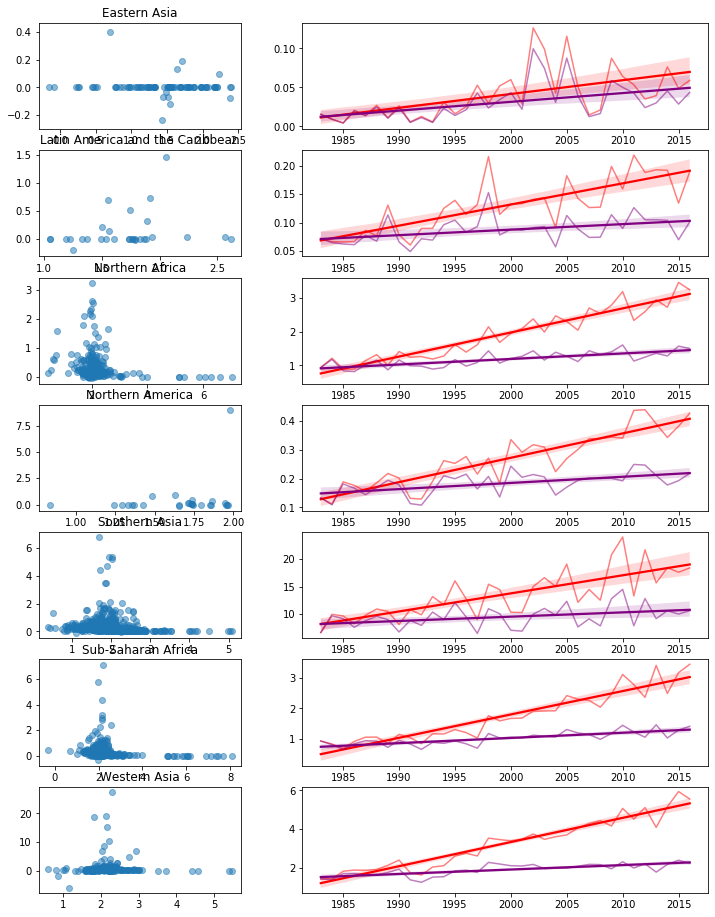

In [139]:
from matplotlib import gridspec

fig = plt.figure(figsize = (12, 16))
gs = gridspec.GridSpec(ncols = 2, nrows= 7, width_ratios=[1, 2])

a = 0
b = 0
j = 0

for i, region in enumerate(sig_regions):
    
    df_region = df_data[df_data[geog] == region] # select region
    
    countries = pop_stat(df_region, 'ID_HDC_G0', stat) # get stats
    countries = countries[countries['p_value'] < 0.05] # subset

    # Plot % change pop vs. slope of people days
    axs[j] = plt.subplot(gs[i,0])
    axs[j].scatter(np.log10(countries['p_delt']), countries['coef']/10**5, alpha = 0.5)
    axs[j].set_title(region, fontsize = 12)
    
    b = a + 1
    
    # Plot time series
    axs[j] = plt.subplot(gs[i, 1])
    data = df_data[df_data[geog] == region].groupby('year')['people_days'].sum() / 10**9
    years = list(data.index)
    axs[j].plot(data, color = 'red', linestyle = '-', alpha = 0.5)
    #axs[i].fill_between(years, data, color = 'red', alpha = 0.05, label='_nolegend_')
    sns.regplot(years, data, color = 'red', ax = axs[j], scatter = False, truncate = True)
    
    # people days 83 plot
    data = df_data[df_data[geog] == region].groupby('year')['people_days_heat'].sum() / 10**9
    years = list(data.index)
    axs[j].plot(data, color = 'purple', linestyle = '-', alpha = 0.5)
    #axs[i].fill_between(years, data, color = 'purple', alpha = 0.1, label='_nolegend_')
    sns.regplot(years, data, color = 'purple', ax = axs[j], scatter = False, truncate = True)
    axs[j].set_ylabel('')
    
    a = b + 1
    
    
#     print(c)
#     # Title
#     axs[c].title.set_text(region)
    
#     counter = counter + i
#     if counter == 0:
#         axs[i].set_ylabel('People-days [hundred-thousands]', fontsize = 13)
    # Set lims
#     axs[i].set_ylim(bottom = 0)
#     #axs[i].set_xlim([0, 800])


    
#     #print(countries['CTR_MN_NM'])
    
#     for j, row in countries.iterrows():
#         axs[i].annotate(row['CTR_MN_NM'], (row['p_delt'], row['coef']))

Text(0.5, 1.0, '0,1')

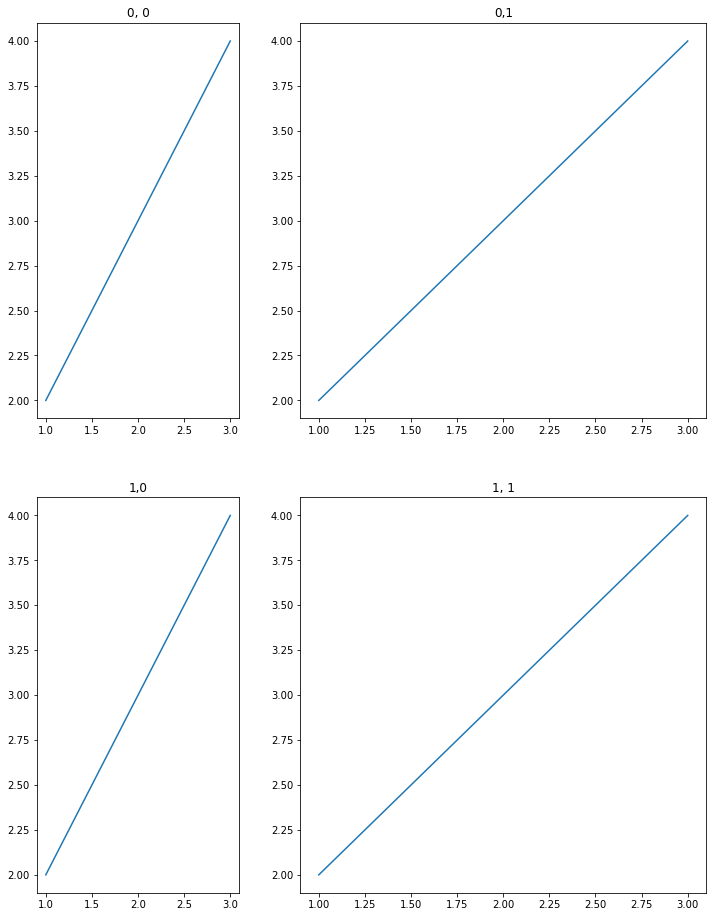

In [138]:
fig = plt.figure(figsize = (12, 16))
gs = gridspec.GridSpec(ncols = 2, nrows= 2, width_ratios=[1, 2])

axs[1] = plt.subplot(gs[0, 0]) 
axs[1].plot([1,2,3], [2,3,4])
axs[1].set_title('0, 0')

axs[2] = plt.subplot(gs[1, 1])
axs[2].plot([1,2,3], [2,3,4])
axs[2].set_title('1, 1')

axs[3] = plt.subplot(gs[1, 0])
axs[3].plot([1,2,3], [2,3,4])
axs[3].set_title('1,0')

axs[4] = plt.subplot(gs[0, 1])
axs[4].plot([1,2,3], [2,3,4])
axs[4].set_title('0,1')

In [ ]:
gs = gridspec.GridSpec(ncols = 2, nrows= 6, width_ratios=[1, 2])


In [111]:
gs

GridSpec(6, 2, width_ratios=[1, 2])

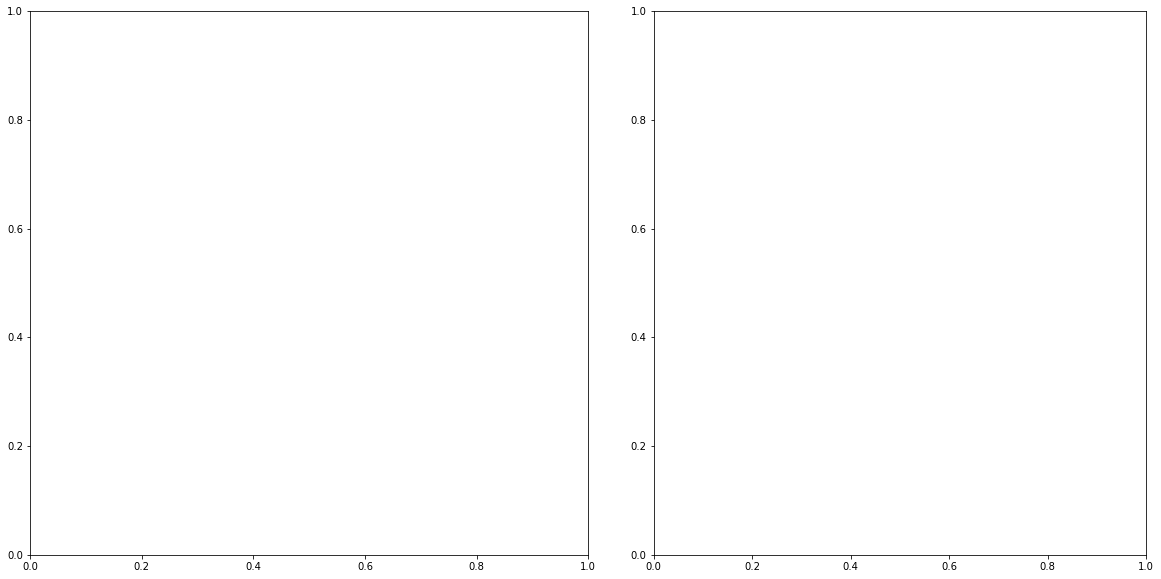

In [119]:
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1,3, width_ratios=[1,2,3], height_ratios=[1])
fig = plot.figure(figsize=(20,10))
ax1 = plot.subplot(gs[:, :-1])
ax2 = plot.subplot(gs[:, -1])


In [ ]:
stat = 'people_days'

df_region_ = pop_stat(df_data, geog, stat)
df_region_ = df_region[df_region['p_value'] < 0.05]
sig_regions_ = list(df_region[geog])

df_region = df_region.merge(df_region_, on = geog, how = 'inner')

In [ ]:
df_region

In [ ]:
fig, axs = plt.subplots(1, figsize = (10, 10), sharex=True)
axs.scatter(df_region['p_delt_x'], df_region['coef_x'], s = df_region['coef_y']*50,
           c = df_region['coef_y']*50, cmap = 'spring') #df_region['coef'] /10**6)
# plt.yscale('log')
# plt.ylim(bottom = 0)

for i, row in df_region.iterrows():
    print(row['sub-region'])
    plt.annotate(row['sub-region'], (row['p_delt_x'], row['coef_x']),
                fontsize = 16) #row['coef']/10**6))

# Title
axs.set_title('Population Increase verse Exposure Increase \n due to Extreme Heat', fontsize = 20)
axs.set_ylabel('Person days [Millions/ Year] \nincrease due to extreme heat', fontsize = 20)
axs.set_xlabel('Urban Population Change 1983 - 2016 (%)', fontsize = 20)
axs.tick_params(labelsize = 10)

In [ ]:
fig, axs = plt.subplots(4, figsize = (15, 8), sharex=True)
axs = axs.ravel()
plt.ylim(0, .02)

for i, region in enumerate(sig_regions):
    
    df_region = df_data[df_data['region'] == region] # select region
    countries = pop_stat(df_region, 'CTR_MN_NM', stat) # get stats
    countries = countries[countries['p_value'] < 0.05] # subset
    
    # plot it
    axs[i].scatter(countries['p_delt'], countries['coef'])
    axs[i].set_title(region)
    
    # Set lims
#     axs[i].set_ylim(bottom = 0)
#     #axs[i].set_xlim([0, 800])


    
    #print(countries['CTR_MN_NM'])
    
    for j, row in countries.iterrows():
        axs[i].annotate(row['CTR_MN_NM'], (row['p_delt'], row['coef']))


In [ ]:
stat = 'total_days'
df_region = pop_stat(df_data, 'CTR_MN_NM', stat)
df_region = df_region[df_region['p_value'] < 0.05]

In [ ]:
fig, axs = plt.subplots(1, figsize = (10, 10), sharex=True)
axs.scatter(df_region['p_delt'], df_region['coef'])
# plt.yscale('log')
plt.ylim(top=100)

for j, row in df_region.iterrows():
    axs.annotate(row['CTR_MN_NM'], (row['p_delt'], row['coef']))

# Old Code

In [ ]:
for label, df_geog in df.groupby('ID_HDC_G0'):

    # Get Data
    X_year = np.array(df_geog.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df_geog.groupby('year')['total_days'].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit()
    print(label, model.params)
    print(len(model.params))
    print('P Value is', model.pvalues[0])
#     coef = model.params[1] # first param in intercept coef, second is slope of line
#     r2 = model.rsquared_adj
#     p = model.pvalues[0]

In [ ]:
test = df_data[df_data['CTR_MN_NM'] == 'Nigeria']
test[test['year'] == 1983]['total_days'].sum()

In [ ]:
test = test[test['ID_HDC_G0'] == 3101]
test

In [ ]:
X_year = np.array(test.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
Y_stats = np.array(test.groupby('year')['total_days'].sum()).reshape((-1, 1))

In [ ]:
# Add Intercept
X_year_2 = sm.add_constant(X_year)

# Regress
model = sm.OLS(Y_stats, X_year_2).fit()

In [ ]:
plt.scatter(X_year, Y_stats)
plt.scatter(X_year, model.predict(X_year_2), color = 'red')

In [ ]:
model.summary()

In [ ]:
# test reg and plot
test = df_data[df_data['CTR_MN_NM'] == 'India']
stats = 'people_days'

# X & Y 
X_year = np.array(test.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
Y_stats = np.array(test.groupby('year')[stats].sum()).reshape((-1, 1))

In [ ]:
plt.scatter(X_year, Y_stats)

In [ ]:
X_year_2 = sm.add_constant(X_year)
model_int = sm.OLS(Y_stats, X_year_2).fit()
pred_int = model_int.predict(X_year_2)
plt.scatter(X_year, pred_int, color = 'red')
plt.title('W/ Intercept')

In [ ]:
model_int.summary()

In [ ]:
model = sm.OLS(Y_stats, X_year).fit()
model.summary()

In [ ]:
plt.scatter(X_year, pred_int, color = 'red')
plt.scatter(X_year, Y_stats, color = 'blue')

In [ ]:
df = df_data[df_data['CTR_MN_NM'] == 'Nigeria']

In [ ]:
test = pop_stat(df_data, 'sub-region', 'total_days')

In [ ]:
df = test[test['p_value'] < 0.01]

In [ ]:
df_out

In [ ]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

ax1.scatter(df_out['p_delt'], df_out['coef'])
#plt.xscale('log')
#plt.yscale('log')
# plt.xlim(100, 700)
# plt.ylim(0, 100)

for i, row in df_out.iterrows():
    plt.annotate(row['sub-region'], (row['p_delt'], row['coef']))


# Label Points
    #loop through data points and plot each point 
#     for l, row in data.loc[data['label']==label,:].iterrows():
    
#         #add the data point as text
#         plt.annotate(row['label'], 
#                      (row['x'], row['y']),
#                      horizontalalignment='center',
#                      verticalalignment='center',
#                      size=11,
#                      color=customPalette[i]) 


# # Title
# ax1.set_title('Change in Population vs Change in Extreme Heat', fontsize = 20)
# ax1.set_ylabel('Avg. Additional Days Per Year > 40.6C ', fontsize = 20)
# ax1.set_xlabel('Change in Population (%) 1983 - 2016', fontsize = 20)
# ax1.tick_params(labelsize = 15)

In [ ]:
ct = df_data[df_data['sub-region'] == 'Sub-Saharan Africa']
df_out = pop_stat(ct, 'ID_HDC_G0', 'total_days')
df_out = df_out[df_out['p_value'] < 0.01]
df_out

In [ ]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

ax1.scatter(df_out['p_delt'], df_out['coef'])
plt.xscale('log')
plt.xlim(0,10000)

# for i, row in df_out.iterrows():
#     plt.annotate(row['ID_HDC_G0'], (row['p_delt'], row['coef']))


In [ ]:
def pop_stat(df, geog, stats):
    
    """Finds linear coef for increase in stat by a given geography from 1983 - 2016, as well
    as the pct change in population of the cities within the given geography"""

    # Get results
    labels = []
    delt_list = []
    r2_list = []
    coef_list = []
    p_list = []
    df_out = pd.DataFrame()

    for label, df_geog in df.groupby(geog):

        # Get Data
        X_year = np.array(df_geog.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
        Y_stats = np.array(df_geog.groupby('year')[stats].sum()).reshape((-1, 1))

        # Add Intercept
        X_year_2 = sm.add_constant(X_year)

        # Regress
        model = sm.OLS(Y_stats, X_year_2).fit() 
        
        # Get slope
        # first param in intercept coef, second is slope of line but if slope = 0, then intecept
        if len(model.params) == 2:
            coef = model.params[1]
            
        else:
            coef = model.params[0]
        
        # R2 and P
        r2 = model.rsquared_adj
        p = model.pvalues[0]

        # Pop change
        delt = (df_geog['P2016'].sum() - df_geog['P1983'].sum())/df_geog['P1983'].sum() * 100

        # Make lists
        labels.append(label)
        r2_list.append(r2)
        coef_list.append(coef)
        p_list.append(p)
        delt_list.append(delt)

    # Make data frame
    df_out[geog] = labels
    df_out['p_delt'] = delt_list
    df_out['r2'] = r2_list
    df_out['coef'] = coef_list
    df_out['p_value'] = [round(elem, 4) for elem in p_list]

    return df_out